In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fft_index_to_k(N):
    k = np.arange(N)
    k[k > N//2] -= N
    return k

def truncated_series_2d(coeffs, X, Y, G):
    coeffs = np.asarray(coeffs)
    Nx, Ny = coeffs.shape
    kx = fft_index_to_k(Nx)          # shape (Nx,)
    ky = fft_index_to_k(Ny)          # shape (Ny,)

    mask_x = np.abs(kx) <= G
    mask_y = np.abs(ky) <= G
    coeffs_win = coeffs[np.ix_(mask_x, mask_y)]

    kx_win = kx[mask_x][:, None]
    ky_win = ky[mask_y][None, :]

    phase = np.exp(2j * np.pi * (kx_win[..., None, None] * X + ky_win[..., None, None] * Y))

    S = (coeffs_win[..., None, None] * phase).sum(axis=(0, 1)) / (Nx * Ny)
    return S.real

$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 1, rel L2 = 5.809e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 2, rel L2 = 4.514e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 3, rel L2 = 3.816e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 4, rel L2 = 3.363e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 5, rel L2 = 3.039e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 6, rel L2 = 2.790e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 7, rel L2 = 2.592e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 8, rel L2 = 2.428e-01
$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$: G= 9, rel L2 = 2.290e-01
$

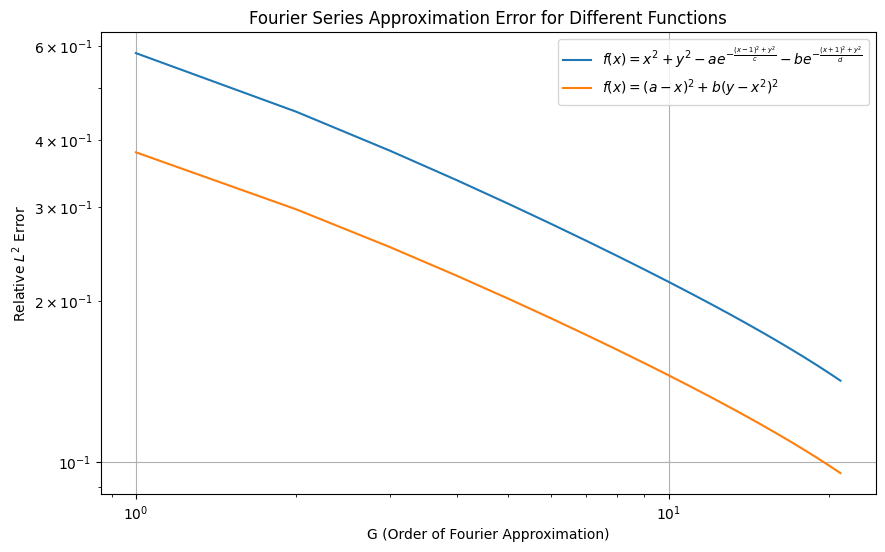

In [3]:
def func1(x, y, a=1.5, b=1.0, c=0.5, d=0.5):
    return x**2 + y**2 - a * np.exp(-((x - 1)**2 + y**2) / c) - b * np.exp(-((x + 1)**2 + y**2) / d)

def func2(x, y, a=1, b=2):
    return (a - x)**2 + b*(y - x**2)**2

test_funcs_2d = [func1, func2]
function_names_latex = [
    r"$f(x) = x^2 + y^2 - a e^{-\frac{(x-1)^2 + y^2}{c}} - b e^{-\frac{(x+1)^2 + y^2}{d}}$",
    r"$f(x) = (a - x)^2 + b(y - x^2)^2$",
]

# Discretize x over [0, 1]
x_values = np.linspace(0, 1, 1000)+1e-2

Nx = Ny = 100
G_max = 21
epsilon = 1e-2
x = np.linspace(epsilon, 1.0, Nx)
y = np.linspace(epsilon, 1.0, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')
points_2d = np.column_stack([X.ravel(), Y.ravel()])
Lx = Ly = 1 - epsilon

# Initialize the plot
plt.figure(figsize=(10, 6))

fourier_errors_2d = []

for func, name in zip(test_funcs_2d, function_names_latex):
    f_vals = func(X, Y)

    coeffs = np.fft.fft2(f_vals)
    kx = fft_index_to_k(Nx).reshape(-1, 1)
    ky = fft_index_to_k(Ny).reshape( 1, -1)
    coeffs *= np.exp(-2j*np.pi*(kx*epsilon + ky*epsilon))

    # L2 norm of the true function on the continuous domain
    dA = (Lx * Ly) / (Nx * Ny)
    norm_f = np.sqrt(np.sum(np.abs(f_vals) ** 2) * dA)

    errors = []
    for G in range(1, G_max + 1):
        S_G = truncated_series_2d(coeffs, X, Y, G)

        err = np.sqrt(np.sum((f_vals - S_G) ** 2) * dA) / norm_f
        errors.append(err)
        print(f"{name}: G={G:2d}, rel L2 = {err:.3e}")

    plt.plot(range(1, G_max + 1), errors, label=name)
    fourier_errors_2d.append(errors)

# Finalize the plot
plt.xlabel('G (Order of Fourier Approximation)')
plt.ylabel('Relative $L^2$ Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Fourier Series Approximation Error for Different Functions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def calc_params_fourier(G):
    return (2*G+1)**2

def calc_params_sinekan(G1, H, G2):
    dim_A1 = 2 * G1 * H
    dim_b1 = H
    dim_A2 = H * G2
    dim_b2 = 1
    dim_w1 = G1
    dim_w2 = G2
    return dim_A1 + dim_b1 + dim_A2 + dim_b2 + dim_w1 + dim_w2

def calc_params_mlp2(H):
    dim_W1 = 2 * H
    dim_b1 = H
    dim_w2 = H
    dim_b2 = 1
    return dim_W1 + dim_b1 + dim_w2 + dim_b2

In [ ]:
def _matmul_flops(M, K, B=1, N=1):
    """
    FLOPs (mult+add) for B * (M x K) @ (K x N)  ➜  B * (M x N).

    mult  : B * M * K * N
    add   : B * M * K * N (one add per multiply for dense matmul)
    """
    mul = B * M * K * N
    add = mul
    return mul, add


def calc_flops_sinekan(G1, H, G2, B=1, N=1):
    """
    N   : input_dim
    G1  : sines per input dim (layer 1)
    H   : hidden units (layer 1 output)
    G2  : sines per hidden unit (layer 2)
    B   : batch size
    """
    mul = add = sin = 0

    mul += B * N * G1
    add += B * N * G1
    sin += B * N * G1

    m_mul, m_add = _matmul_flops(M=1, K=N*G1, N=H, B=B)
    mul += m_mul
    add += m_add
    add += B * H

    mul += B * H * G2
    add += B * H * G2
    sin += B * H * G2

    mul += B * H * G2
    add += B * H * G2
    add += B

    flops = mul + add + SINE_SF * sin
    return int(flops)


def calc_flops_mlp2_relu(H, B=1, N=1):
    mul = add = relu = 0

    # layer 1 affine
    m_mul, m_add = _matmul_flops(M=1, K=N, N=H, B=B)
    mul += m_mul
    add += m_add + B*H

    # ReLU
    relu += B * H

    # output layer
    mul += B * H
    add += B * H
    add += B

    return int(mul + add + RELU_SF*relu)

def calc_flops_mlp2_sine(H, B=1, N=1):
    # same as ReLU version + trig cost
    mul = add = sine = 0

    # layer 1 affine
    m_mul, m_add = _matmul_flops(M=1, K=N, N=H, B=B)
    mul += m_mul
    add += m_add + B*H

    # sine activation
    sine += B * H

    # output layer
    mul += B * H
    add += B * H + B

    return int(mul + add + SINE_SF*sine)

def calc_flops_truncated_fourier(G, P=1, trig_cost=10):
    Kx = 2 * G + 1
    Ky = 2 * G + 1
    K  = Kx * Ky

    mul_per   = 3 + 4
    add_per   = 1 + 2 + 2
    trig_per  = 2 * trig_cost

    flops_per_coeff = mul_per + add_per + trig_per

    flops = P * (K * flops_per_coeff)

    flops += P

    return int(flops)

In [6]:
with open('/content/drive/MyDrive/sinekan_multi_dim_errors_func1.pkl', 'rb') as f:
    sinekan_errors_1 = pkl.load(f)

In [7]:
with open('/content/drive/MyDrive/sinekan_multi_dim_errors_func2.pkl', 'rb') as f:
    sinekan_errors_2 = pkl.load(f)

In [8]:
sinekan_errors =  sinekan_errors_1 + sinekan_errors_2

In [9]:
with open('/content/drive/MyDrive/mlp_2layer_relu_multi_dim_errors.pkl', 'rb') as f:
    mlp2_relu_errors = pkl.load(f)

In [10]:
mlp2_relu_errors = np.array(mlp2_relu_errors)

In [11]:
with open('/content/drive/MyDrive/mlp_2layer_sine_multi_dim_errors_func1.pkl', 'rb') as f:
    mlp2_sine_errors_1 = pkl.load(f)

In [12]:
with open('/content/drive/MyDrive/mlp_2layer_sine_multi_dim_errors_func2.pkl', 'rb') as f:
    mlp2_sine_errors_2 = pkl.load(f)

In [13]:
mlp2_sine_errors =  mlp2_sine_errors_1 + mlp2_sine_errors_2

In [14]:
with open('/content/drive/MyDrive/sinekan_multi_dim_settings_func1.pkl', 'rb') as f:
    sinekan_params_1 = pkl.load(f)

In [15]:
with open('/content/drive/MyDrive/sinekan_multi_dim_settings_func2.pkl', 'rb') as f:
    sinekan_params_2 = pkl.load(f)

In [16]:
with open('/content/drive/MyDrive/mlp_2layer_relu_multi_dim_settings.pkl', 'rb') as f:
    mlp2_relu_params = pkl.load(f)

In [17]:
with open('/content/drive/MyDrive/mlp_2layer_sine_multi_dim_settings_func1.pkl', 'rb') as f:
    mlp2_sine_params_1 = pkl.load(f)

In [18]:
with open('/content/drive/MyDrive/mlp_2layer_sine_multi_dim_settings_func2.pkl', 'rb') as f:
    mlp2_sine_params_2 = pkl.load(f)

In [20]:
sinekan_params = sinekan_params_1 + sinekan_params_2
mlp2_sine_params = mlp2_sine_params_1 + mlp2_sine_params_2

In [21]:
# Numpy scale factors
SINE_SF = 12
RELU_SF = 1.5

In [22]:
sinekan_p = [calc_params_sinekan(*p[1:]) for p in sinekan_params]
sinekan_p = sinekan_p[:len(sinekan_p)//2]

In [23]:
sinekan_f = [calc_flops_sinekan(*p[1:]) for p in sinekan_params]
sinekan_f = sinekan_f[:len(sinekan_f)//2]

In [24]:
mlp2_relu_p = [calc_params_mlp2(p[1]) for p in mlp2_relu_params]
mlp2_relu_p = mlp2_relu_p[:len(mlp2_relu_p)//2]

In [25]:
mlp2_relu_f = [calc_flops_mlp2_relu(p[1]) for p in mlp2_relu_params]
mlp2_relu_f = mlp2_relu_f[:len(mlp2_relu_f)//2]

In [26]:
mlp2_sine_p = [calc_params_mlp2(*p[1:]) for p in mlp2_sine_params]
mlp2_sine_p = mlp2_sine_p[:len(mlp2_sine_p)//2]

In [27]:
mlp2_sine_f = [calc_flops_mlp2_sine(p[1]) for p in mlp2_sine_params]
mlp2_sine_f = mlp2_sine_f[:len(mlp2_sine_f)//2]

In [28]:
fourier_p = [calc_params_fourier(g) for g in range(1, 22)]

In [29]:
fourier_f = [calc_flops_truncated_fourier(g) for g in range(1, 22)]

In [30]:
plt.rcParams['font.size'] = 14

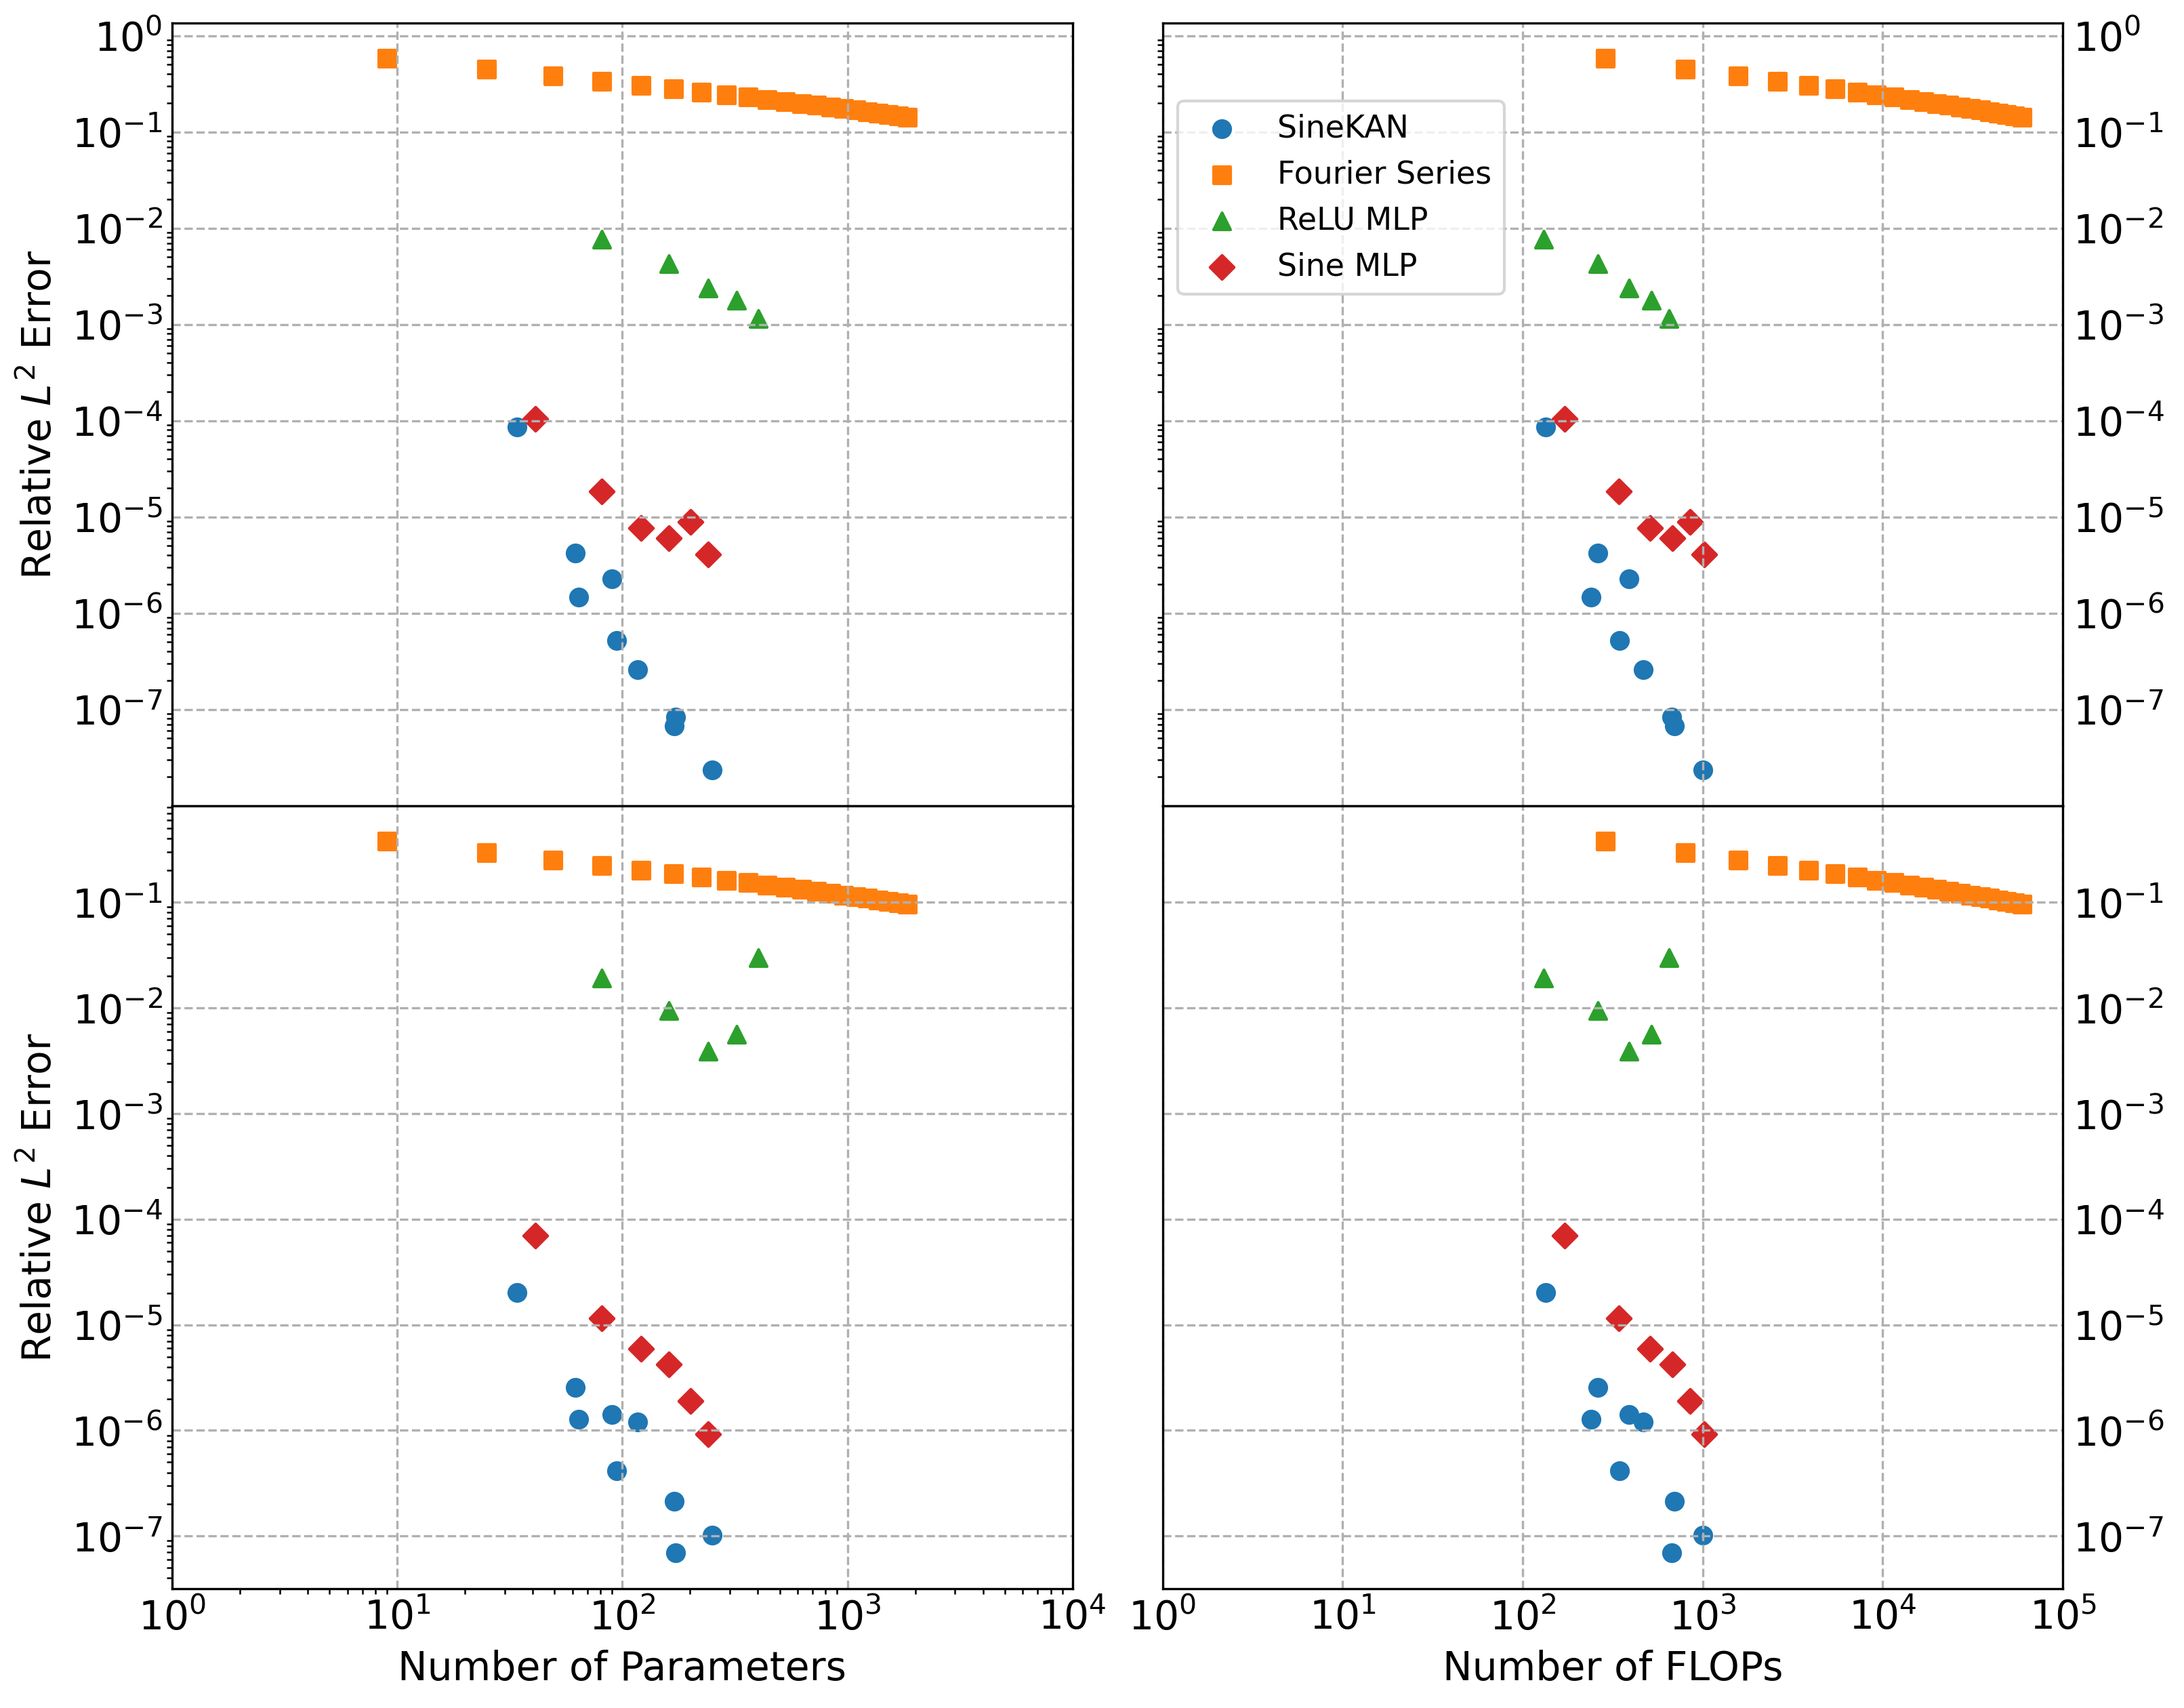

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
for i, (errors, function_name) in enumerate(zip(fourier_errors_2d, function_names_latex)):
    ax[i, 0].scatter(sinekan_p, sinekan_errors[i*len(sinekan_errors)//2:(i+1)*len(sinekan_errors)//2], label='SineKAN', marker='o')
    ax[i, 0].scatter(fourier_p, fourier_errors_2d[i], label='Fourier Series', marker='s')
    ax[i, 0].scatter(mlp2_relu_p, mlp2_relu_errors[i*len(mlp2_relu_errors)//2:(i+1)*len(mlp2_relu_errors)//2], label='ReLU MLP', marker='^')
    ax[i, 0].scatter(mlp2_sine_p, mlp2_sine_errors[i*len(mlp2_sine_errors)//2:(i+1)*len(mlp2_sine_errors)//2], label='Sine MLP', marker='D')
    ax[i, 0].set_ylabel('Relative $L^2$ Error')
    # plt.xscale('log')
    ax[i, 0].set_yscale('log')
    ax[i, 0].set_xscale('log')
    ax[i, 0].set_xlim(1, 1e4)
    ax[i, 0].grid(linestyle='--')
for i, (errors, function_name) in enumerate(zip(fourier_errors_2d, function_names_latex)):
    ax[i, 1].scatter(sinekan_f, sinekan_errors[i*len(sinekan_errors)//2:(i+1)*len(sinekan_errors)//2], label='SineKAN', marker='o')
    ax[i, 1].scatter(fourier_f, fourier_errors_2d[i], label='Fourier Series', marker='s')
    ax[i, 1].scatter(mlp2_relu_f, mlp2_relu_errors[i*len(mlp2_relu_errors)//2:(i+1)*len(mlp2_relu_errors)//2], label='ReLU MLP', marker='^')
    ax[i, 1].scatter(mlp2_sine_f, mlp2_sine_errors[i*len(mlp2_sine_errors)//2:(i+1)*len(mlp2_sine_errors)//2], label='Sine MLP', marker='D')
    # plt.xscale('log')
    ax[i, 1].set_yscale('log')
    ax[i, 1].set_xscale('log')
    ax[i, 1].set_xlim(1, 1e5)
    ax[i, 1].grid(linestyle='--')
ax[1, 0].set_xlabel('Number of Parameters')
ax[1, 1].set_xlabel('Number of FLOPs')
ax[0,0].tick_params(axis='both', labelleft=True, labelbottom=False, length=0)
ax[0,1].tick_params(axis='both', labelleft=False, labelright=True, labelbottom=False, length=0)
ax[1,0].tick_params(axis='both', labelleft=True,  length=0)
ax[1,1].tick_params(axis='both', which='both', labelleft=False, labelright=True,  length=0)
ax[0, 1].legend(bbox_to_anchor=(0., 0., 0.5, 0.92), fontsize=11)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()

In [32]:
# Torch scale factors
SINE_SF = 3.5
RELU_SF = 1

In [33]:
sinekan_p = [calc_params_sinekan(*p[1:]) for p in sinekan_params]
sinekan_p = sinekan_p[:len(sinekan_p)//2]

In [34]:
sinekan_f = [calc_flops_sinekan(*p[1:]) for p in sinekan_params]
sinekan_f = sinekan_f[:len(sinekan_f)//2]

In [35]:
mlp2_relu_p = [calc_params_mlp2(p[1]) for p in mlp2_relu_params]
mlp2_relu_p = mlp2_relu_p[:len(mlp2_relu_p)//2]

In [36]:
mlp2_relu_f = [calc_flops_mlp2_relu(p[1]) for p in mlp2_relu_params]
mlp2_relu_f = mlp2_relu_f[:len(mlp2_relu_f)//2]

In [37]:
mlp2_sine_p = [calc_params_mlp2(*p[1:]) for p in mlp2_sine_params]
mlp2_sine_p = mlp2_sine_p[:len(mlp2_sine_p)//2]

In [38]:
mlp2_sine_f = [calc_flops_mlp2_sine(p[1]) for p in mlp2_sine_params]
mlp2_sine_f = mlp2_sine_f[:len(mlp2_sine_f)//2]

In [39]:
fourier_p = [calc_params_fourier(g) for g in range(1, 22)]

In [40]:
fourier_f = [calc_flops_truncated_fourier(g) for g in range(1, 22)]

In [41]:
plt.rcParams['font.size'] = 14

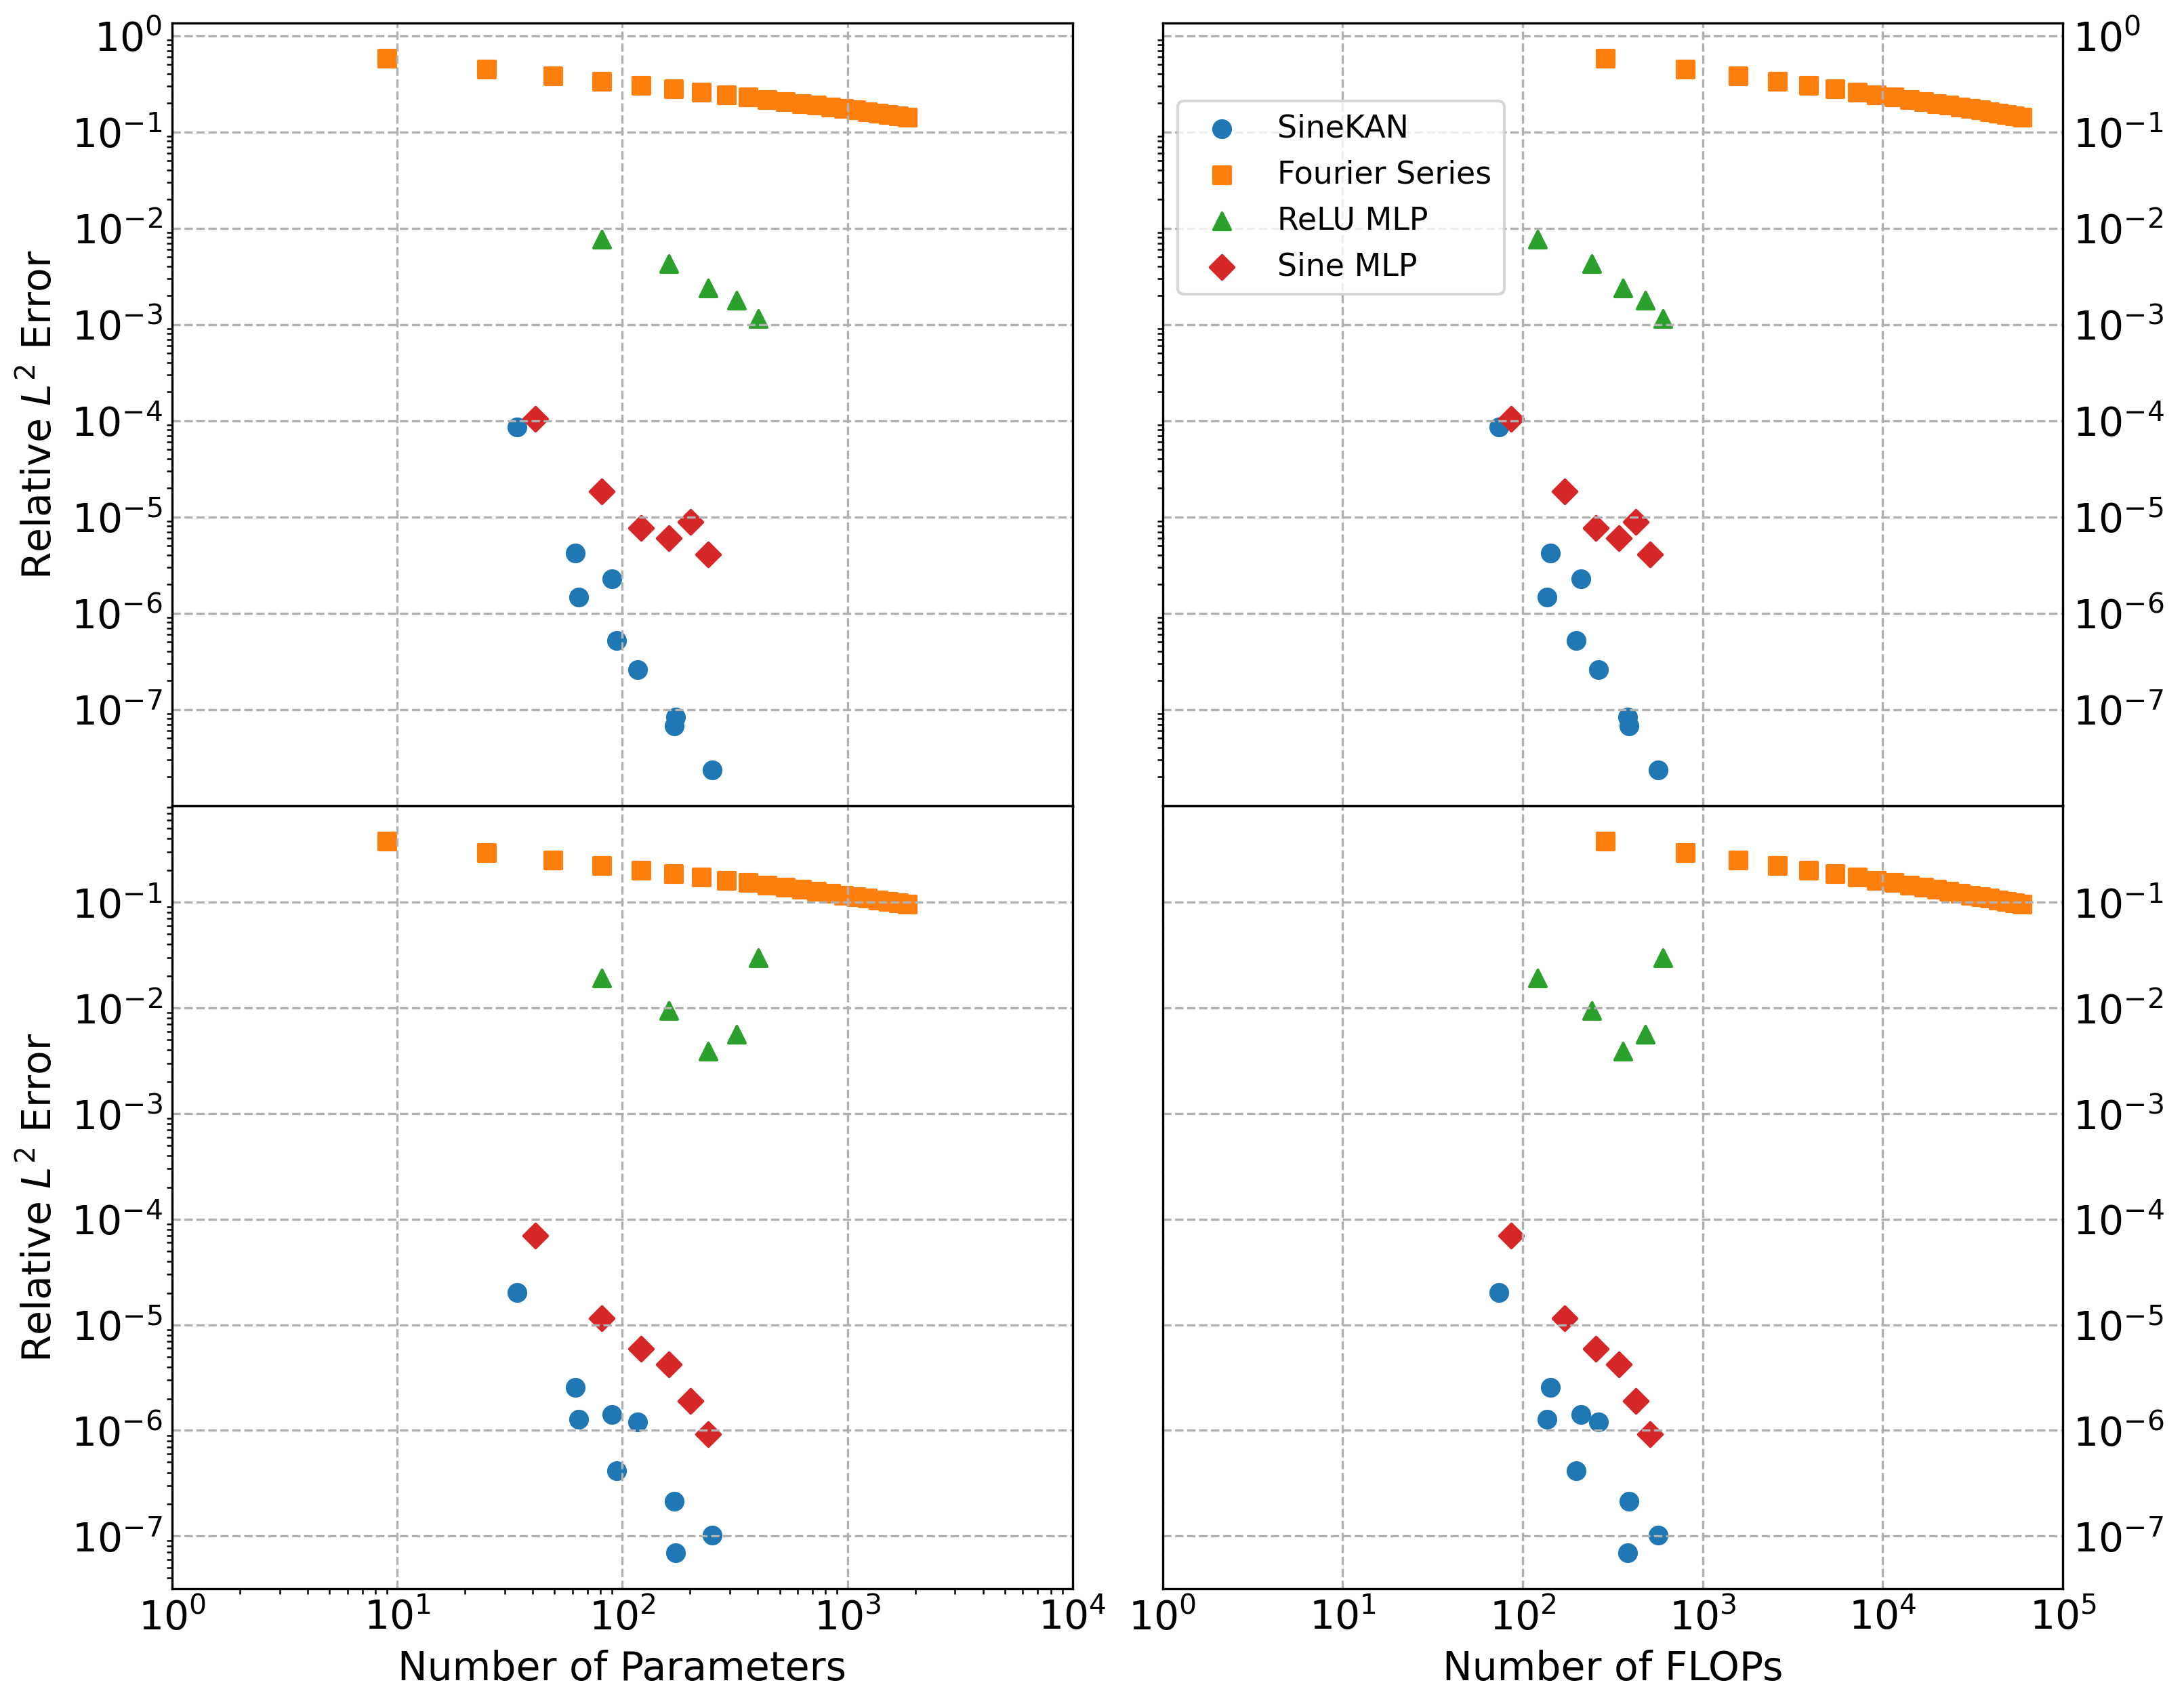

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
for i, (errors, function_name) in enumerate(zip(fourier_errors_2d, function_names_latex)):
    ax[i, 0].scatter(sinekan_p, sinekan_errors[i*len(sinekan_errors)//2:(i+1)*len(sinekan_errors)//2], label='SineKAN', marker='o')
    ax[i, 0].scatter(fourier_p, fourier_errors_2d[i], label='Fourier Series', marker='s')
    ax[i, 0].scatter(mlp2_relu_p, mlp2_relu_errors[i*len(mlp2_relu_errors)//2:(i+1)*len(mlp2_relu_errors)//2], label='ReLU MLP', marker='^')
    ax[i, 0].scatter(mlp2_sine_p, mlp2_sine_errors[i*len(mlp2_sine_errors)//2:(i+1)*len(mlp2_sine_errors)//2], label='Sine MLP', marker='D')
    ax[i, 0].set_ylabel('Relative $L^2$ Error')
    # plt.xscale('log')
    ax[i, 0].set_yscale('log')
    ax[i, 0].set_xscale('log')
    ax[i, 0].set_xlim(1, 1e4)
    ax[i, 0].grid(linestyle='--')
for i, (errors, function_name) in enumerate(zip(fourier_errors_2d, function_names_latex)):
    ax[i, 1].scatter(sinekan_f, sinekan_errors[i*len(sinekan_errors)//2:(i+1)*len(sinekan_errors)//2], label='SineKAN', marker='o')
    ax[i, 1].scatter(fourier_f, fourier_errors_2d[i], label='Fourier Series', marker='s')
    ax[i, 1].scatter(mlp2_relu_f, mlp2_relu_errors[i*len(mlp2_relu_errors)//2:(i+1)*len(mlp2_relu_errors)//2], label='ReLU MLP', marker='^')
    ax[i, 1].scatter(mlp2_sine_f, mlp2_sine_errors[i*len(mlp2_sine_errors)//2:(i+1)*len(mlp2_sine_errors)//2], label='Sine MLP', marker='D')
    # plt.xscale('log')
    ax[i, 1].set_yscale('log')
    ax[i, 1].set_xscale('log')
    ax[i, 1].set_xlim(1, 1e5)
    ax[i, 1].grid(linestyle='--')
ax[1, 0].set_xlabel('Number of Parameters')
ax[1, 1].set_xlabel('Number of FLOPs')
ax[0,0].tick_params(axis='both', labelleft=True, labelbottom=False, length=0)
ax[0,1].tick_params(axis='both', labelleft=False, labelright=True, labelbottom=False, length=0)
ax[1,0].tick_params(axis='both', labelleft=True,  length=0)
ax[1,1].tick_params(axis='both', which='both', labelleft=False, labelright=True,  length=0)
ax[0, 1].legend(bbox_to_anchor=(0., 0., 0.5, 0.92), fontsize=11)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()

In [43]:
# Numpy scale factors
SINE_SF = 1.5
RELU_SF = 12

In [44]:
print(sinekan_params)

[('func1', 2, 5, 1), ('func1', 2, 10, 1), ('func1', 2, 15, 1), ('func1', 4, 5, 2), ('func1', 4, 10, 2), ('func1', 4, 15, 2), ('func1', 6, 5, 3), ('func1', 6, 10, 3), ('func1', 6, 15, 3), ('func2', 2, 5, 1), ('func2', 2, 10, 1), ('func2', 2, 15, 1), ('func2', 4, 5, 2), ('func2', 4, 10, 2), ('func2', 4, 15, 2), ('func2', 6, 5, 3), ('func2', 6, 10, 3), ('func2', 6, 15, 3)]


In [45]:
sinekan_p_h5 = [calc_params_sinekan(*p[1:]) for p in sinekan_params[0::3]]
sinekan_p_h5 = sinekan_p_h5[:len(sinekan_p_h5)//2]

In [46]:
sinekan_f_h5 = [calc_flops_sinekan(*p[1:]) for p in sinekan_params[0::3]]
sinekan_f_h5 = sinekan_f_h5[:len(sinekan_f_h5)//2]

In [47]:
sinekan_errors_h5 = sinekan_errors[0::3]

In [48]:
sinekan_p_h10 = [calc_params_sinekan(*p[1:]) for p in sinekan_params[1::3]]
sinekan_p_h10 = sinekan_p_h10[:len(sinekan_p_h10)//2]

In [49]:
sinekan_f_h10 = [calc_flops_sinekan(*p[1:]) for p in sinekan_params[1::3]]
sinekan_f_h10 = sinekan_f_h10[:len(sinekan_f_h10)//2]

In [50]:
sinekan_errors_h10 = sinekan_errors[1::3]

In [51]:
sinekan_p_h15 = [calc_params_sinekan(*p[1:]) for p in sinekan_params[2::3]]
sinekan_p_h15 = sinekan_p_h15[:len(sinekan_p_h15)//2]

In [52]:
sinekan_f_h15 = [calc_flops_sinekan(*p[1:]) for p in sinekan_params[2::3]]
sinekan_f_h15 = sinekan_f_h15[:len(sinekan_f_h15)//2]

In [53]:
sinekan_errors_h15 = sinekan_errors[2::3]

In [54]:
mlp2_relu_p = [calc_params_mlp2(p[1]) for p in mlp2_relu_params]
mlp2_relu_p = mlp2_relu_p[:len(mlp2_relu_p)//2]

In [55]:
mlp2_relu_f = [calc_flops_mlp2_relu(p[1]) for p in mlp2_relu_params]
mlp2_relu_f = mlp2_relu_f[:len(mlp2_relu_f)//2]

In [56]:
mlp2_sine_p = [calc_params_mlp2(*p[1:]) for p in mlp2_sine_params]
mlp2_sine_p = mlp2_sine_p[:len(mlp2_sine_p)//2]

In [57]:
mlp2_sine_f = [calc_flops_mlp2_sine(p[1]) for p in mlp2_sine_params]
mlp2_sine_f = mlp2_sine_f[:len(mlp2_sine_f)//2]

In [58]:
fourier_p = [calc_params_fourier(g) for g in range(1, 22)]

In [59]:
fourier_f = [calc_flops_truncated_fourier(g) for g in range(1, 22)]

In [60]:
plt.rcParams['font.size'] = 14

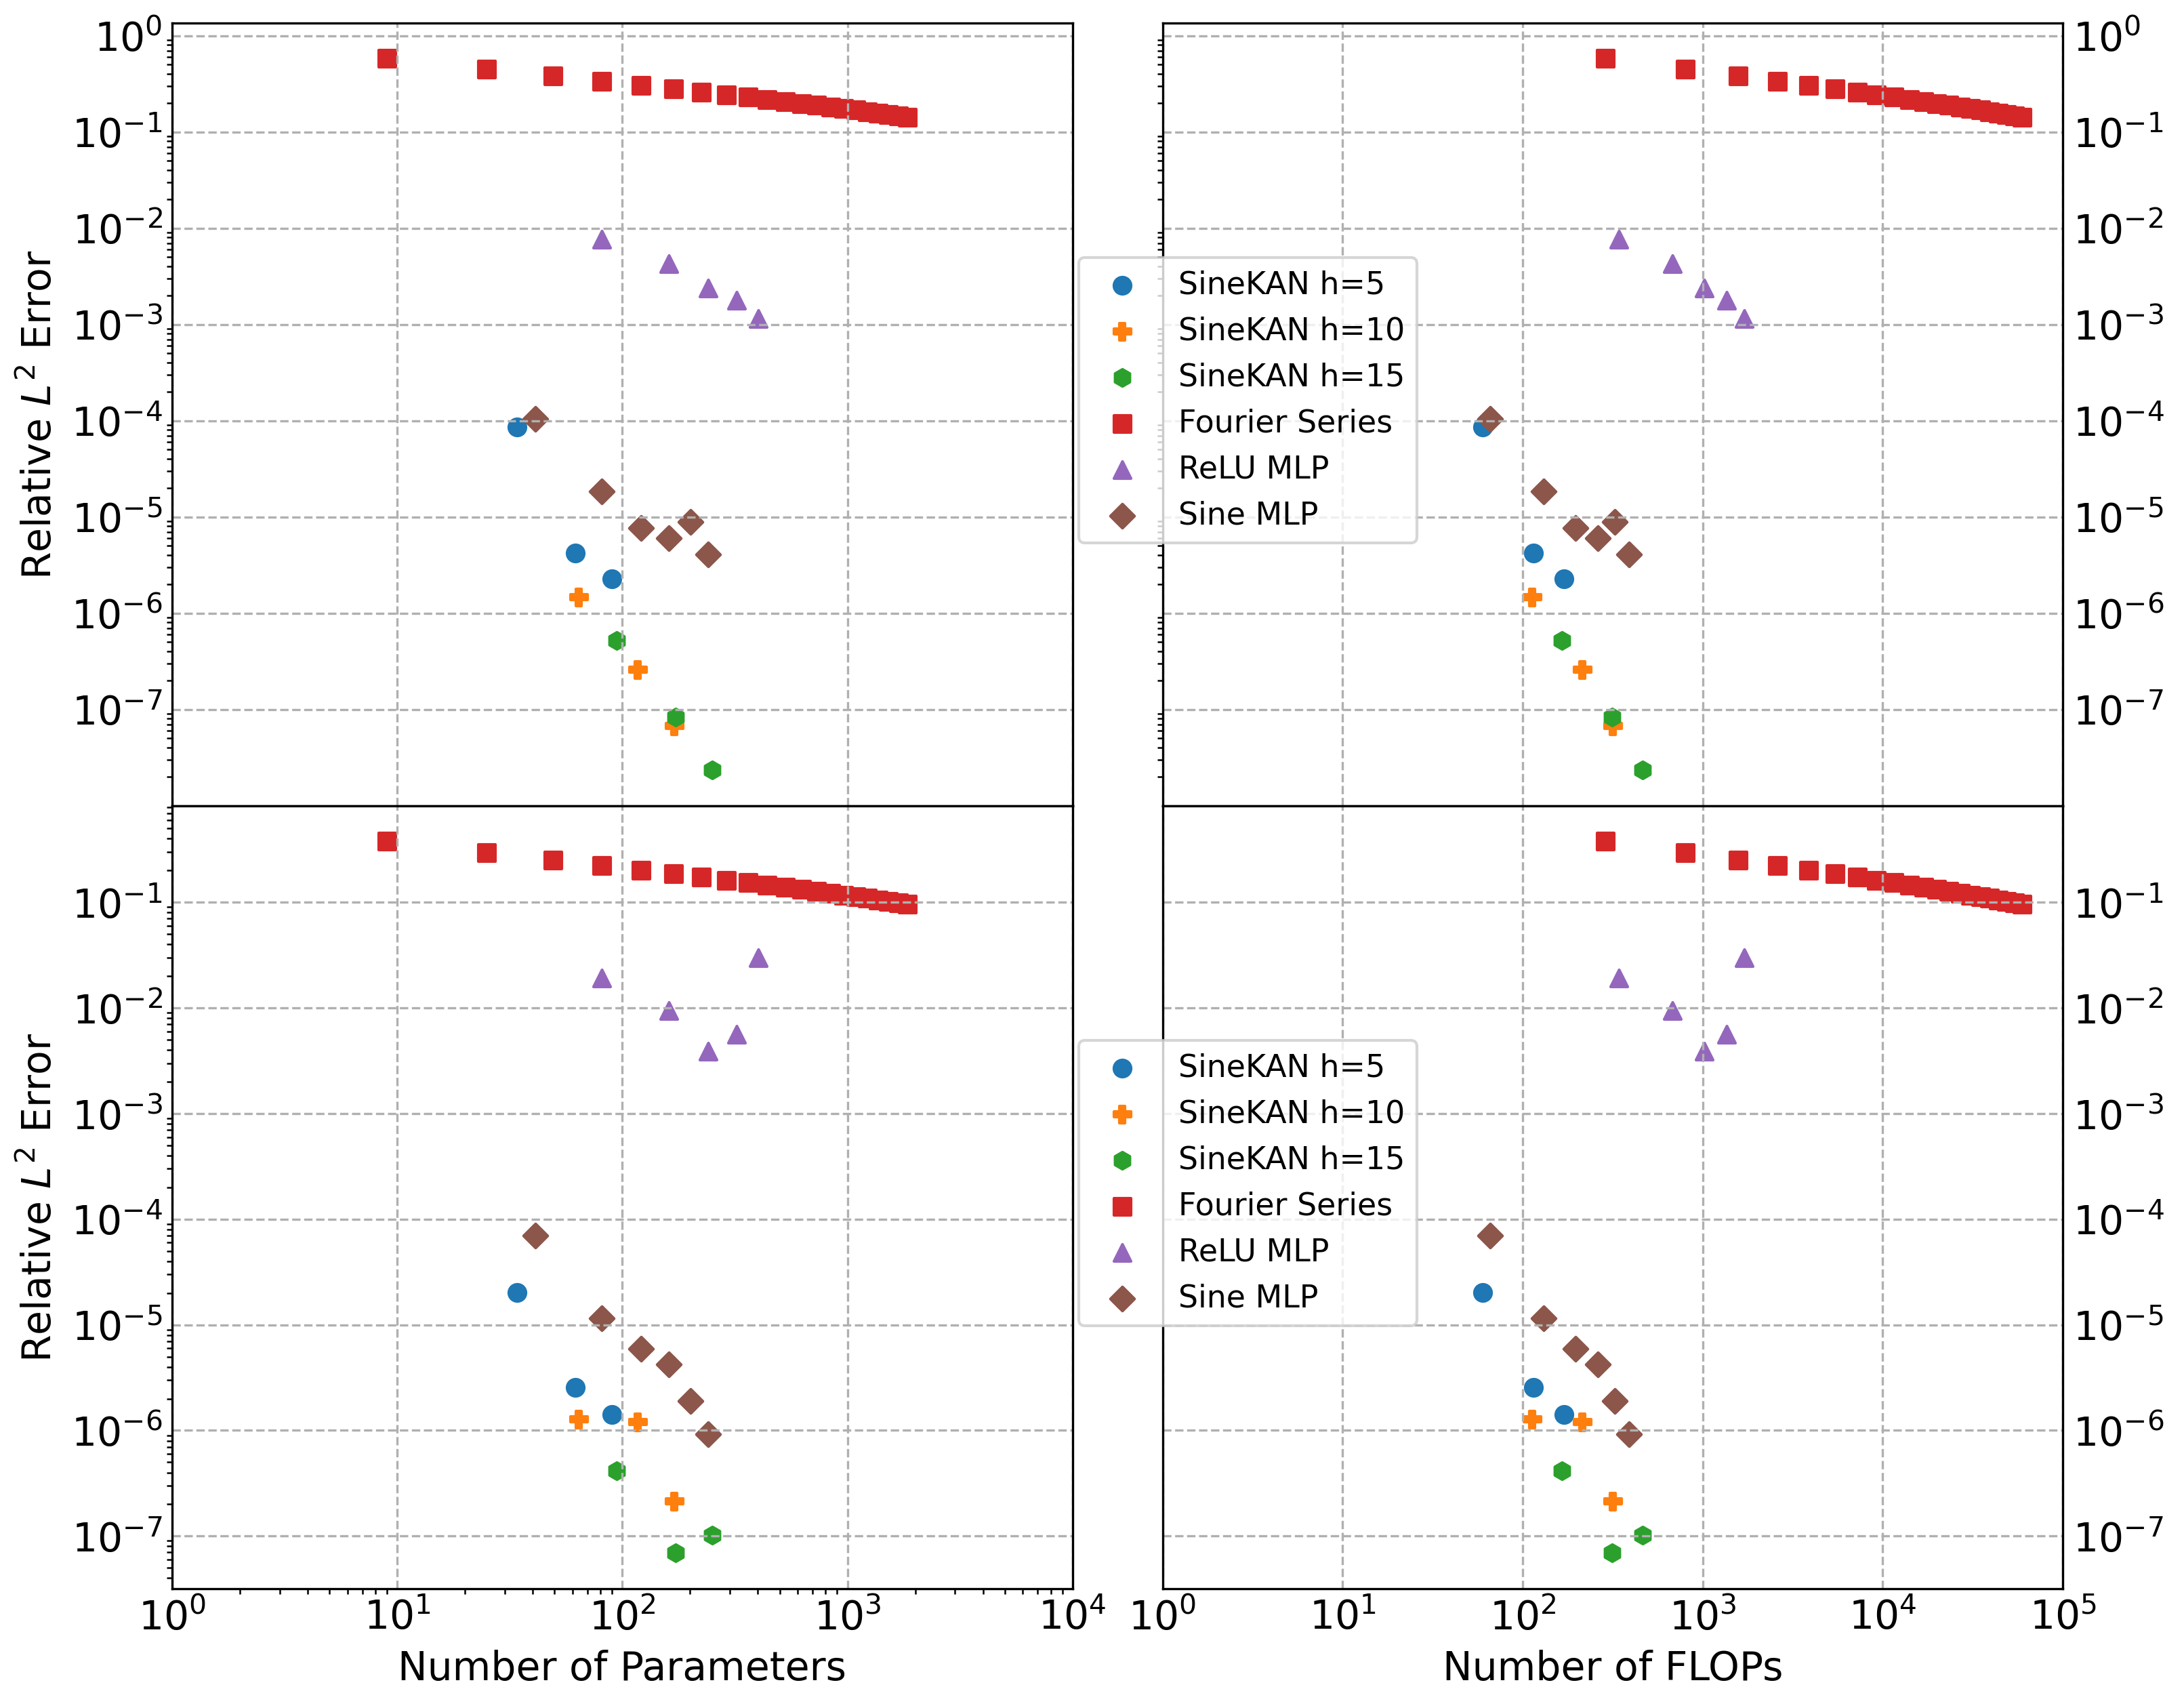

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
for i, (errors, function_name) in enumerate(zip(fourier_errors_2d, function_names_latex)):
    ax[i, 0].scatter(sinekan_p_h5, sinekan_errors_h5[i*len(sinekan_errors_h5)//2:(i+1)*len(sinekan_errors_h5)//2], label='SineKAN h=5', marker='o')
    ax[i, 0].scatter(sinekan_p_h10, sinekan_errors_h10[i*len(sinekan_errors_h10)//2:(i+1)*len(sinekan_errors_h10)//2], label='SineKAN h=10', marker='P')
    ax[i, 0].scatter(sinekan_p_h15, sinekan_errors_h15[i*len(sinekan_errors_h15)//2:(i+1)*len(sinekan_errors_h15)//2], label='SineKAN h=15', marker='h')
    ax[i, 0].scatter(fourier_p, fourier_errors_2d[i], label='Fourier Series', marker='s')
    ax[i, 0].scatter(mlp2_relu_p, mlp2_relu_errors[i*len(mlp2_relu_errors)//2:(i+1)*len(mlp2_relu_errors)//2], label='ReLU MLP', marker='^')
    ax[i, 0].scatter(mlp2_sine_p, mlp2_sine_errors[i*len(mlp2_sine_errors)//2:(i+1)*len(mlp2_sine_errors)//2], label='Sine MLP', marker='D')
    ax[i, 0].set_ylabel('Relative $L^2$ Error')
    # plt.xscale('log')
    ax[i, 0].set_yscale('log')
    ax[i, 0].set_xscale('log')
    ax[i, 0].set_xlim(1, 1e4)
    ax[i, 0].grid(linestyle='--')
for i, (errors, function_name) in enumerate(zip(fourier_errors_2d, function_names_latex)):
    ax[i, 1].scatter(sinekan_f_h5, sinekan_errors_h5[i*len(sinekan_errors_h5)//2:(i+1)*len(sinekan_errors_h5)//2], label='SineKAN h=5', marker='o')
    ax[i, 1].scatter(sinekan_f_h10, sinekan_errors_h10[i*len(sinekan_errors_h10)//2:(i+1)*len(sinekan_errors_h10)//2], label='SineKAN h=10', marker='P')
    ax[i, 1].scatter(sinekan_f_h15, sinekan_errors_h15[i*len(sinekan_errors_h15)//2:(i+1)*len(sinekan_errors_h15)//2], label='SineKAN h=15', marker='h')
    ax[i, 1].scatter(fourier_f, fourier_errors_2d[i], label='Fourier Series', marker='s')
    ax[i, 1].scatter(mlp2_relu_f, mlp2_relu_errors[i*len(mlp2_relu_errors)//2:(i+1)*len(mlp2_relu_errors)//2], label='ReLU MLP', marker='^')
    ax[i, 1].scatter(mlp2_sine_f, mlp2_sine_errors[i*len(mlp2_sine_errors)//2:(i+1)*len(mlp2_sine_errors)//2], label='Sine MLP', marker='D')
    # plt.xscale('log')
    ax[i, 1].set_yscale('log')
    ax[i, 1].set_xscale('log')
    ax[i, 1].set_xlim(1, 1e5)
    ax[i, 1].grid(linestyle='--')
ax[1, 0].set_xlabel('Number of Parameters')
ax[1, 1].set_xlabel('Number of FLOPs')
ax[0,0].tick_params(axis='both', labelleft=True, labelbottom=False, length=0)
ax[0,1].tick_params(axis='both', labelleft=False, labelright=True, labelbottom=False, length=0)
ax[1,0].tick_params(axis='both', labelleft=True,  length=0)
ax[1,1].tick_params(axis='both', which='both', labelleft=False, labelright=True,  length=0)
ax[0, 1].legend(bbox_to_anchor=(-0.2, -0.2, 0.5, 0.92), fontsize=11)
ax[1, 1].legend(bbox_to_anchor=(-0.2, -0.2, 0.5, 0.92), fontsize=11)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()